In [2]:
%run ..\Functions.ipynb
from scipy.stats import linregress

In [3]:
fig_folder = r'.\figures\ensemble_uncertainty'
fhs=glob.glob(r"E:\WaPORQA\ERA5\Ensemble\*_spread_*.nc")
ds= xr.open_mfdataset(fhs)
ds

<xarray.Dataset>
Dimensions:    (longitude: 181, latitude: 161, time: 14608)
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.5 -29.0 -28.5 ... 59.0 59.5 60.0
  * latitude   (latitude) float32 40.0 39.5 39.0 38.5 ... -39.0 -39.5 -40.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2022-12-31T21:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8, 161, 181), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8, 161, 181), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(8, 161, 181), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8, 161, 181), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(8, 161, 181), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(8, 161, 181), meta=np.ndarray>
    ssrdc      (time, latitude, longitude) float32 dask.array<chunksize=(8, 161, 181), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 13:15:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# plot

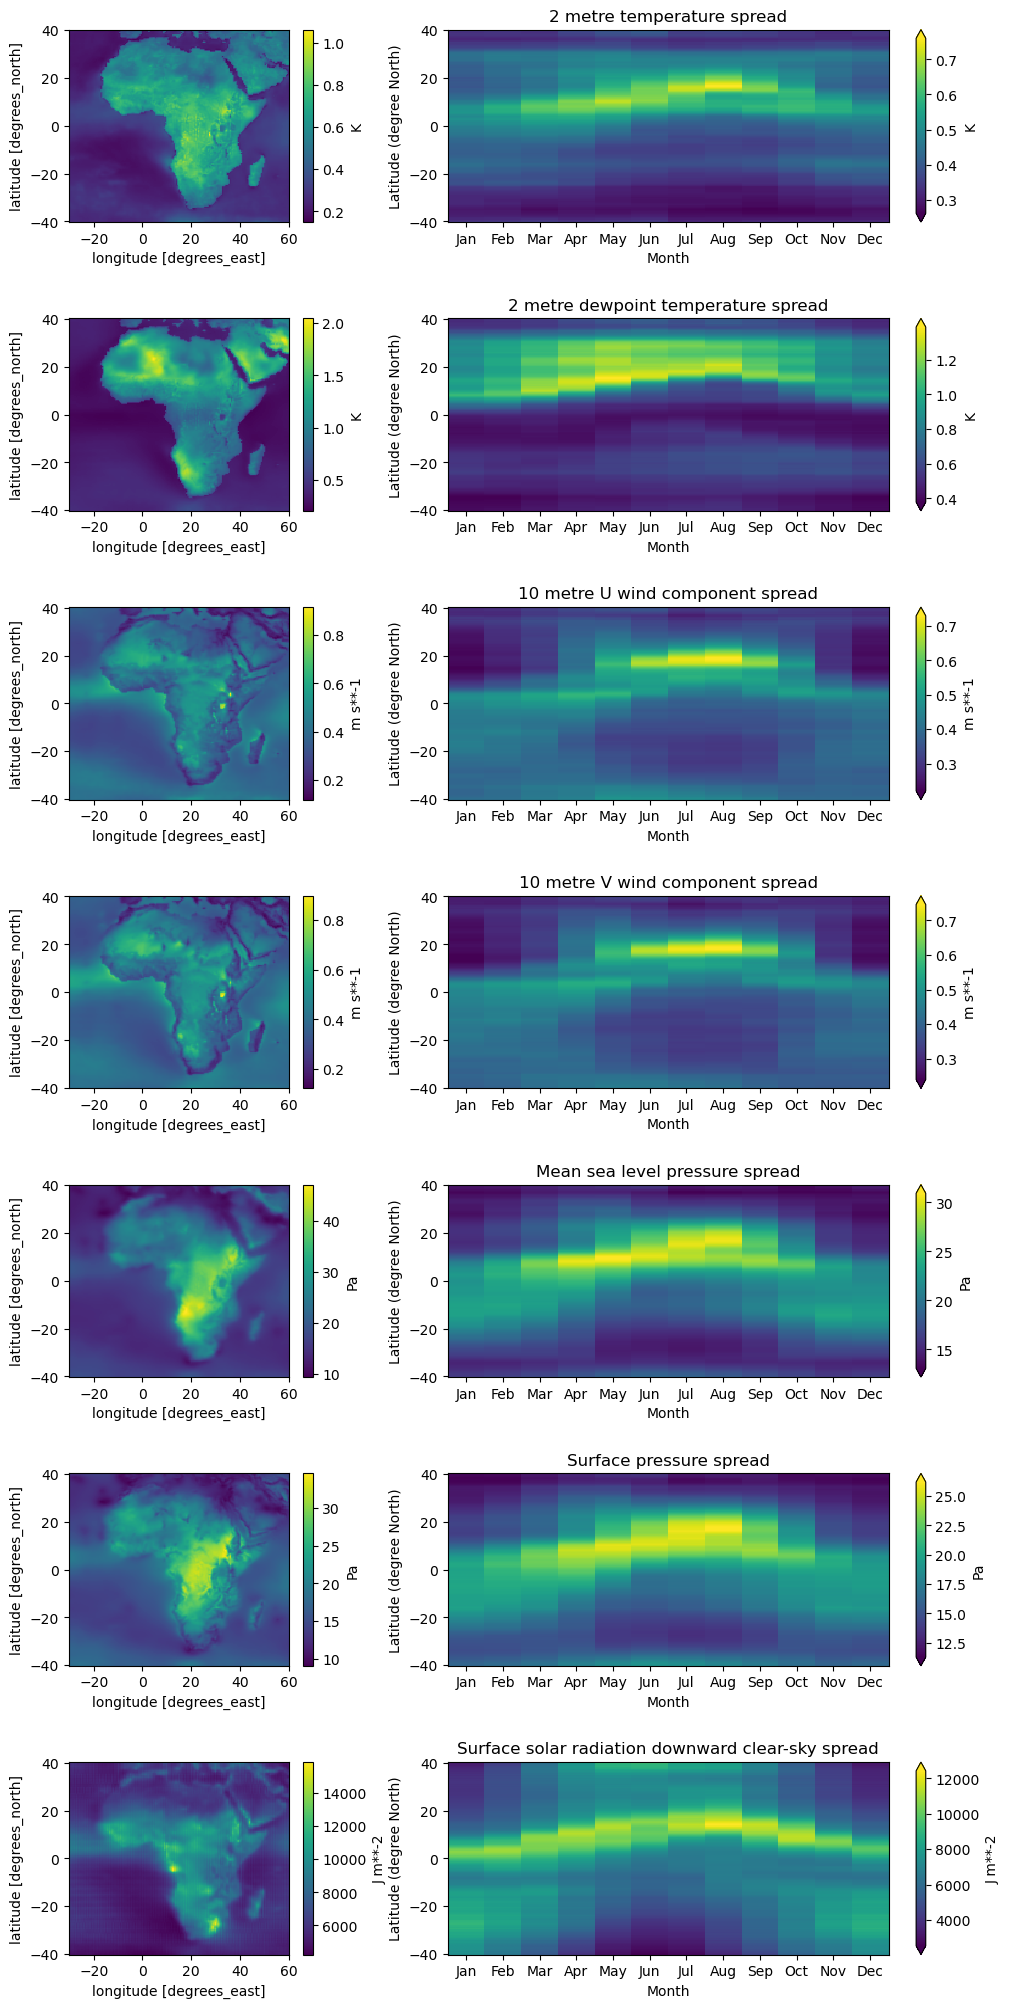

In [8]:
fig, axs = plt.subplots(nrows=7, ncols=2, 
                        figsize=(12,25),
                        gridspec_kw={'width_ratios': [0.5, 1], 
                                                       'height_ratios': [1, 1, 1, 1, 1, 1, 1], 
                                                       'wspace': 0.25,  
                                                       'hspace': 0.5})
varss = ['t2m','d2m','u10','v10','msl','sp','ssrdc']
for i in range(len(varss)) :
    var = varss[i]
    da=ds[var]
    da_mean = da.mean(dim = 'time')
    plot=da_mean.plot(ax=axs[i,0])
    cbar = plot.colorbar
    cbar.set_label(da.units)
    plot_hovmoller_month(da, '{0} spread'.format(da.long_name), 
                         dimension = ["longitude","latitude"],
                         ax=axs[i,1], 
                         varname = da.units,
                         cmap='viridis'
                       )
plt.savefig(os.path.join(fig_folder,'ERA5_ensemble_spread.png'),bbox_inches='tight')

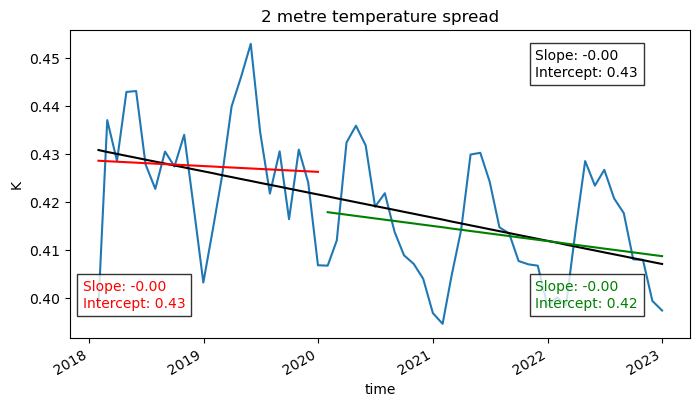

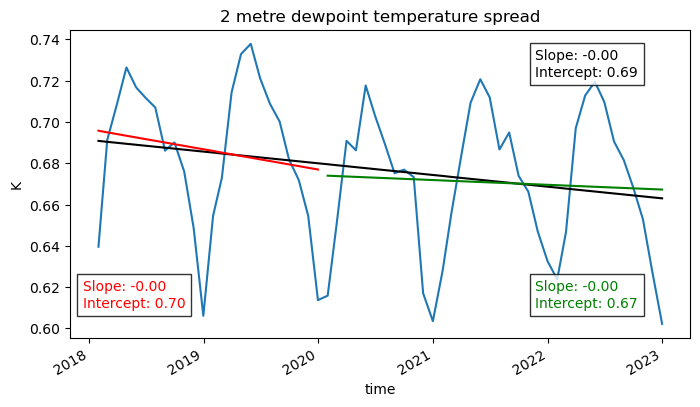

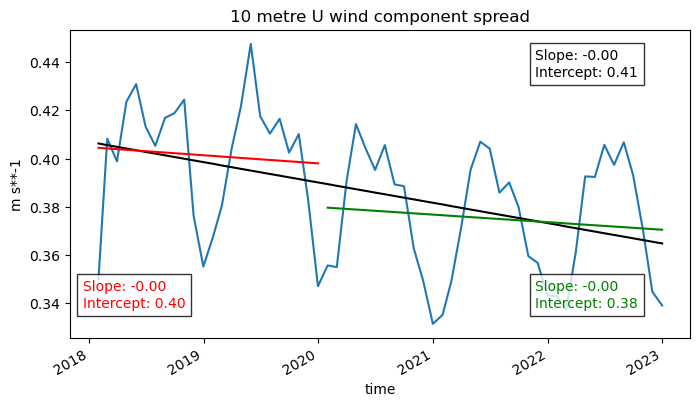

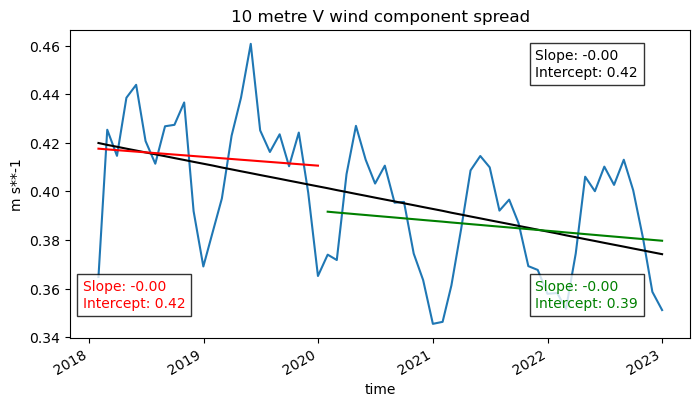

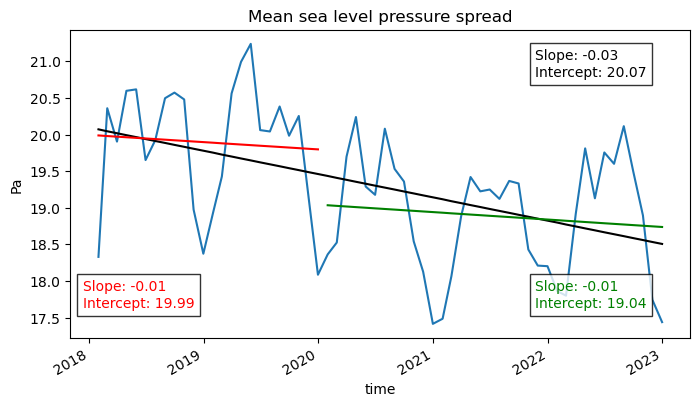

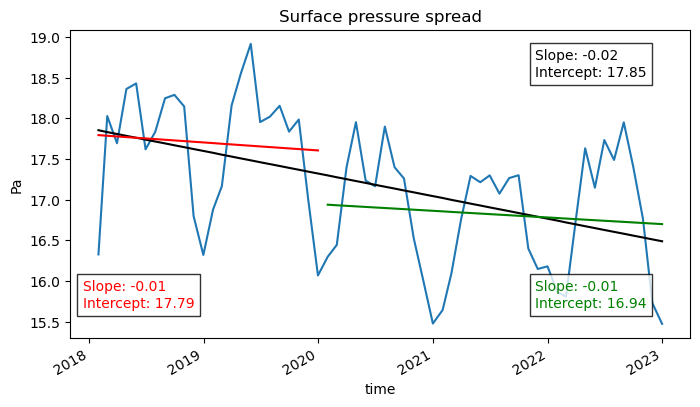

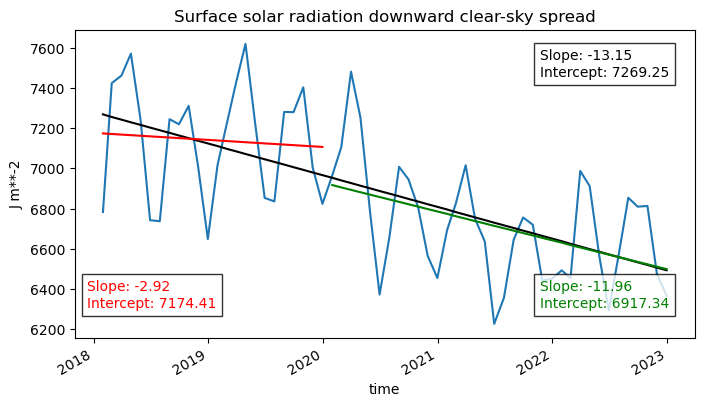

In [26]:
varss = ['t2m','d2m','u10','v10','msl','sp','ssrdc']
for i in range(len(varss)) :
    var = varss[i]
    da=ds[var]   
    da_ts=da.mean(dim=['latitude','longitude'])
    monthly_ts = da_ts.resample(time='1M').mean()

    # Separate data before and after 2020
    before_ts = monthly_ts[monthly_ts.time <= np.datetime64('2020-01-01')]
    after_ts = monthly_ts[monthly_ts.time >= np.datetime64('2020-01-01')]
    
    #plot ts
    fig,ax=plt.subplots(figsize=(8,4))
    monthly_ts.plot(ax=ax) 
    ax.set_title('{0} spread'.format(da.long_name))
    ax.set_ylabel(da.units)
    
    #### plot trend
    # Calculate the trend line using numpy's polyfit
    time_values = np.arange(len(monthly_ts))
    trend_coefficients = np.polyfit(time_values, monthly_ts, 1)
    trend_line = np.polyval(trend_coefficients, time_values)
    
    time_values_before = np.arange(len(before_ts))
    trend_coefficients_before = np.polyfit(time_values_before, before_ts, 1)
    trend_line_before = np.polyval(trend_coefficients_before, time_values_before)
    
    time_values_after = np.arange(len(after_ts))
    trend_coefficients_after = np.polyfit(time_values_after, after_ts, 1)
    trend_line_after = np.polyval(trend_coefficients_after, time_values_after)    

    # Plot the trend line
    ax.plot(monthly_ts.time, trend_line, color='black', label='Trend Line')
    ax.plot(before_ts.time, trend_line_before, color='red')
    ax.plot(after_ts.time, trend_line_after, color='green')    

    # Get the trend statistics using linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_values, monthly_ts)
    # Display trend statistics as text in the plot
    # trend_stats_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR-squared: {r_value**2:.4f}\nP-value: {p_value:.4f}"
    trend_stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.75, 0.85, trend_stats_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

    # Get the trend statistics using linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_values_before, before_ts)
    # Display trend statistics as text in the plot
    # trend_stats_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR-squared: {r_value**2:.4f}\nP-value: {p_value:.4f}"
    trend_stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.02, 0.1, trend_stats_text, transform=ax.transAxes, color = 'red',bbox=dict(facecolor='white', alpha=0.8))

    # Get the trend statistics using linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_values_after, after_ts)
    # Display trend statistics as text in the plot
    # trend_stats_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR-squared: {r_value**2:.4f}\nP-value: {p_value:.4f}"
    trend_stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.75, 0.1, trend_stats_text, transform=ax.transAxes, color = 'green', bbox=dict(facecolor='white', alpha=0.8))

            
    
    plt.savefig(os.path.join(fig_folder,'ERA5_ensemble_spread_{0}_ts.png'.format(var)),bbox_inches='tight')

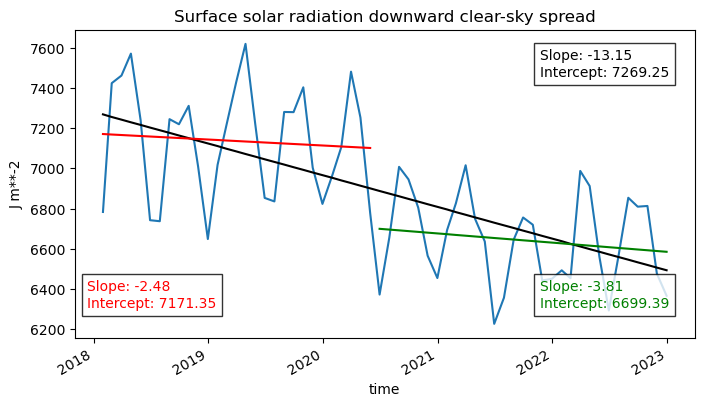

In [27]:
varss = ['ssrdc']
for i in range(len(varss)) :
    var = varss[i]
    da=ds[var]   
    da_ts=da.mean(dim=['latitude','longitude'])
    monthly_ts = da_ts.resample(time='1M').mean()

    # Separate data before and after 2020
    before_ts = monthly_ts[monthly_ts.time <= np.datetime64('2020-06-01')]
    after_ts = monthly_ts[monthly_ts.time >= np.datetime64('2020-06-01')]
    
    #plot ts
    fig,ax=plt.subplots(figsize=(8,4))
    monthly_ts.plot(ax=ax) 
    ax.set_title('{0} spread'.format(da.long_name))
    ax.set_ylabel(da.units)
    
    #### plot trend
    # Calculate the trend line using numpy's polyfit
    time_values = np.arange(len(monthly_ts))
    trend_coefficients = np.polyfit(time_values, monthly_ts, 1)
    trend_line = np.polyval(trend_coefficients, time_values)
    
    time_values_before = np.arange(len(before_ts))
    trend_coefficients_before = np.polyfit(time_values_before, before_ts, 1)
    trend_line_before = np.polyval(trend_coefficients_before, time_values_before)
    
    time_values_after = np.arange(len(after_ts))
    trend_coefficients_after = np.polyfit(time_values_after, after_ts, 1)
    trend_line_after = np.polyval(trend_coefficients_after, time_values_after)    

    # Plot the trend line
    ax.plot(monthly_ts.time, trend_line, color='black', label='Trend Line')
    ax.plot(before_ts.time, trend_line_before, color='red')
    ax.plot(after_ts.time, trend_line_after, color='green')    

    # Get the trend statistics using linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_values, monthly_ts)
    # Display trend statistics as text in the plot
    # trend_stats_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR-squared: {r_value**2:.4f}\nP-value: {p_value:.4f}"
    trend_stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.75, 0.85, trend_stats_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

    # Get the trend statistics using linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_values_before, before_ts)
    # Display trend statistics as text in the plot
    # trend_stats_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR-squared: {r_value**2:.4f}\nP-value: {p_value:.4f}"
    trend_stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.02, 0.1, trend_stats_text, transform=ax.transAxes, color = 'red',bbox=dict(facecolor='white', alpha=0.8))

    # Get the trend statistics using linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_values_after, after_ts)
    # Display trend statistics as text in the plot
    # trend_stats_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR-squared: {r_value**2:.4f}\nP-value: {p_value:.4f}"
    trend_stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.75, 0.1, trend_stats_text, transform=ax.transAxes, color = 'green', bbox=dict(facecolor='white', alpha=0.8))

            
    
    plt.savefig('ERA5_ensemble_spread_{0}_ts.png'.format(var),bbox_inches='tight')

# test

In [ ]:
plot_hovmoller_month(ds.t2m, 't2m spread', dimension = ["longitude","latitude"],
                   )

In [24]:
da = ds.t2m
da_mean = da.mean(dim = 'time')

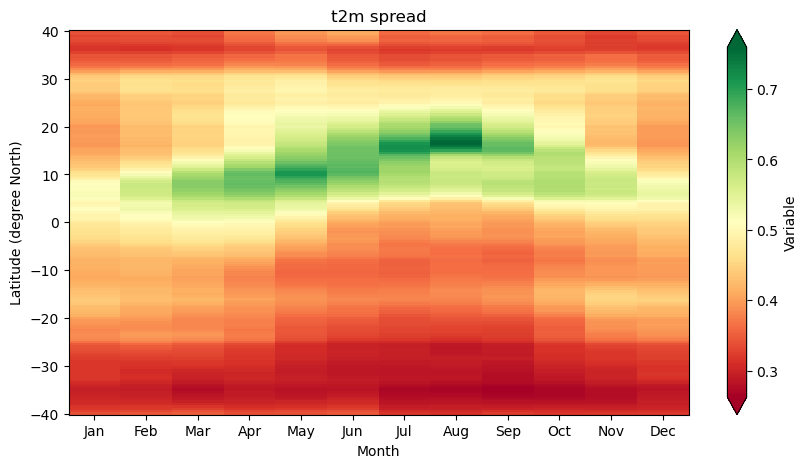

In [27]:
plot_hovmoller_month(da, 't2m spread', dimension = ["longitude","latitude"],
                   )